# Udacity PyTorch Challenge Classification Project - fast.ai

In this project an image classifier is trained to recognize different species of flowers using [the Oxford dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories. 

My [notebook](https://gist.github.com/AlisonDavey/17c5a5c09c7bbf31a3b95515c7cb70e6) for phase 1 of the PyTorch Scholarship Challenge uses PyTorch to achieve 99% accuracy in 30 or so epochs (7 misclassified flowers out of 819).

As a follow-up, the same data is used here using the [fast.ai V1](https://docs.fast.ai/) library which sits on top of Pytorch 1.0. The previous notebook gives the data sources and builds the test set.

This project is very similar to the dog breeds notebook in lesson 1 of the Practical Deep Learning for Coders (2019) course.

This complete notebook runs in 16 minutes on a P100 GPU on GCP to achieve at least 98% accuracy on the test set.

In [1]:
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.40'

In [3]:
from fastai import *
from fastai.vision import *

from torchvision import models as tvmodels

In [4]:
path = Path('./assets/flower_data')

In [5]:
tfms = get_transforms()
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, bs=64, size=256)
data.normalize(imagenet_stats);

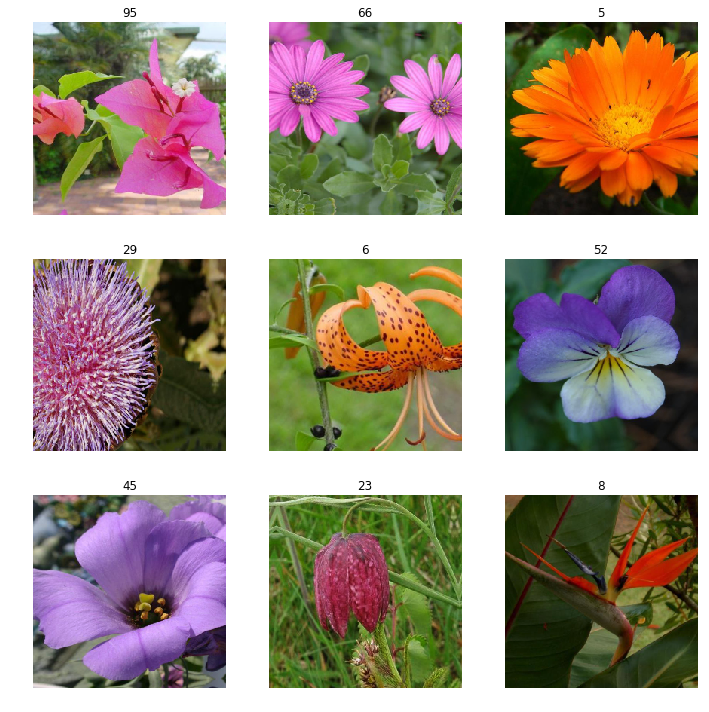

In [6]:
data.show_batch(rows=3, figsize=(10,10))

In [7]:
# Dictionary of flower names from the category/class/folder name
with open('cat_to_name.json', 'r') as f: cat_to_name = json.load(f) 
names=OrderedDict(sorted(cat_to_name.items(), key=lambda t: t[0]))

# Dictionary of classes ('1','99') and labels (0,101)
class_to_idx = {sorted(data.classes)[i]: i for i in range(len(data.classes))}
print ({k: class_to_idx[k] for k in list(class_to_idx)[:5]})

# Reverse dictionary of labels and classes
idx_to_class = {val: key for key, val in class_to_idx.items()}
print ({k: idx_to_class[k] for k in list(idx_to_class)[:5]})


{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4}
{0: '1', 1: '10', 2: '100', 3: '101', 4: '102'}


In [8]:
learn = create_cnn(data, tvmodels.densenet201, metrics=accuracy).to_fp16()

/opt/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


# Training - Stage 1
The head of the model

In [9]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=3840, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=102, bias=True)
)

In [10]:
print(f'{sum(p.numel() for p in learn.model.parameters()):,} total parameters')
train_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'{train_params:,} trainable parameters')

20,120,550 total parameters
2,256,678 trainable parameters


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


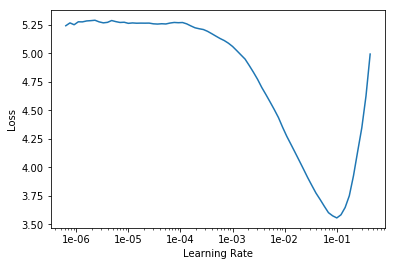

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(2, 1e-2) # train for a couple of epochs only

epoch,train_loss,valid_loss,accuracy
1,0.878946,1.744678,0.592910
2,0.281047,0.107886,0.979218


In [13]:
learn.save('stage-1') # when already around 97%

# Training - Stage 2
The whole model

In [14]:
# Run this to change batch size / image size / fp16
#data = ImageDataBunch.from_folder(path, ds_tfms=tfms, bs=64, size=256)
#data.normalize(imagenet_stats)
#learn = create_cnn(data, tvmodels.densenet201, metrics=accuracy).to_fp16()


In [15]:
learn.load('stage-1');
learn.unfreeze()
print(f'{sum(p.numel() for p in learn.model.parameters()):,} total parameters')
train_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'{train_params:,} trainable parameters')

20,120,550 total parameters
20,120,550 trainable parameters


In [16]:
learn.fit_one_cycle(4,1e-4) 

epoch,train_loss,valid_loss,accuracy
1,0.093118,0.090920,0.987775
2,0.075339,0.108188,0.979218
3,0.041710,0.077879,0.986553
4,0.026177,0.071533,0.987775


In [17]:
learn.fit_one_cycle(4,1e-5) 

epoch,train_loss,valid_loss,accuracy
1,0.026009,0.067534,0.990220
2,0.019740,0.069953,0.986553
3,0.016679,0.068774,0.984108
4,0.016129,0.067166,0.986553


In [18]:
learn.save('stage-2')

# Predictions - Misclassified images
The test data is not Kaggle style unlabelled data but 
is a labelled dataset, similar to the validation data.

In [19]:
# Predicting on the validation dataset, rebuilding the learner without fp16
data = ImageDataBunch.from_folder(path, valid='valid',
                                       ds_tfms=tfms, bs=64, 
                                       size=256)
data.normalize(imagenet_stats)
learn = create_cnn(data, tvmodels.densenet201)
learn.load('stage-2')
interp = ClassificationInterpretation.from_learner(learn, tta=True)
correct = (interp.pred_class==interp.y_true).sum()
print (f'Validation set - correctly classified flowers: {correct} incorrectly: {len(interp.y_true)-correct}\n')


Validation set - correctly classified flowers: 810 incorrectly: 8



In [20]:
# Predicting on the test dataset
data = ImageDataBunch.from_folder(path, valid='test',
                                       ds_tfms=tfms, bs=64, 
                                       size=256)
data.normalize(imagenet_stats)
data.classes = list(names.values())
learn.data = data
interp = ClassificationInterpretation.from_learner(learn, tta=True)
correct = (interp.pred_class==interp.y_true).sum()
print (f'Test set - correctly classified flowers: {correct} incorrectly: {len(interp.y_true)-correct}\n')


Test set - correctly classified flowers: 810 incorrectly: 9



In [21]:
# Index of images with incorrect predictions
idx = [i for i, x in enumerate(a == b for a,b in zip(interp.pred_class, interp.y_true)) if x == 0]
label_errors = set(interp.y_true[idx].numpy())
class_errors = [idx_to_class[x] for x in label_errors]
names_with_errors = [names[str(x)] for x in class_errors]
print ('Classes containing incorrectly classified flowers\n', *names_with_errors, sep=' / ')


Classes containing incorrectly classified flowers
 / camellia / mallow / sweet pea / lenten rose / azalea / common dandelion / corn poppy / hippeastrum


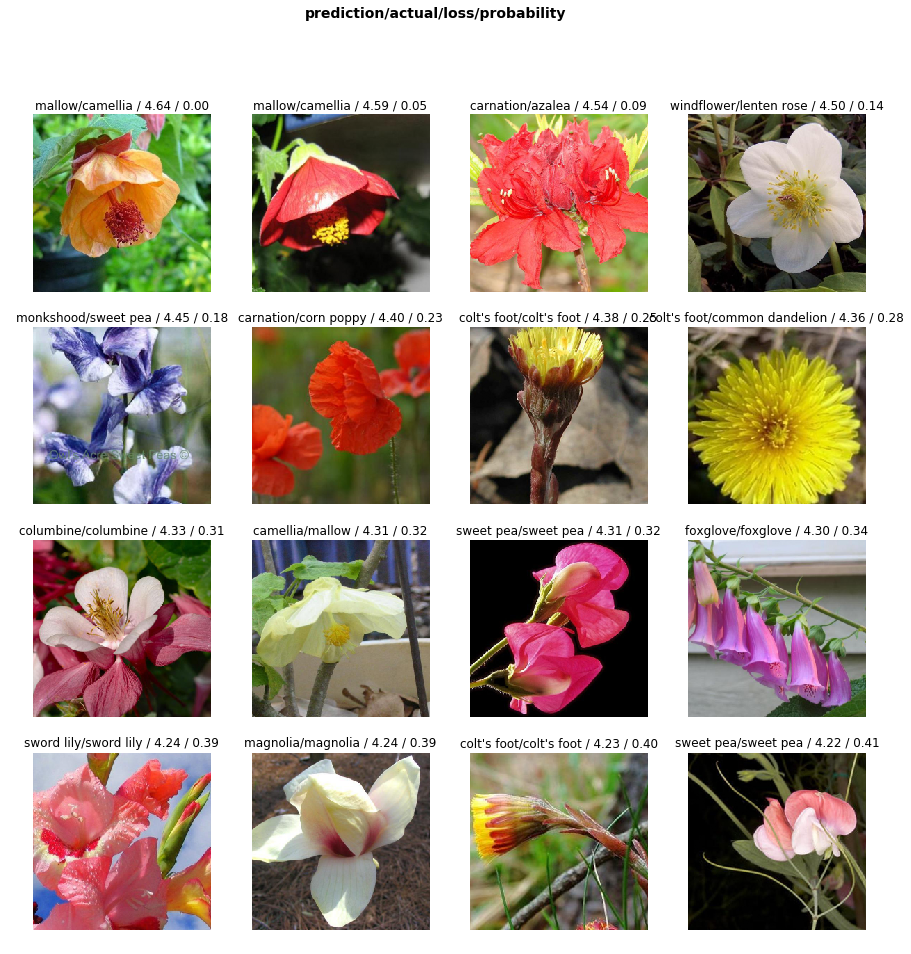

In [22]:
interp.plot_top_losses(16, figsize=(15,15))

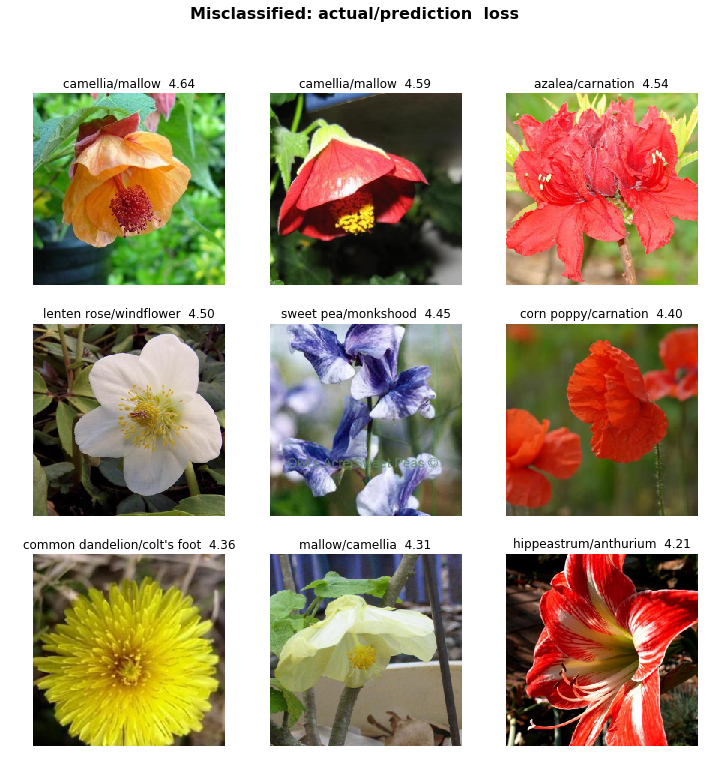

In [23]:
# Adapted from plot_top_losses to show only misclassified images
def plot_misclassified(sorted_idx, k=16, figsize=(12,12)):
    '''Show misclassified images along with their actual class, 
    predicted class and loss'''
    classes = learn.data.classes
    rows = math.ceil(math.sqrt(k))
    fig,axes = plt.subplots(rows,rows,figsize=figsize)
    fig.suptitle('Misclassified: actual/prediction  loss', weight='bold', size=16)
    for i,idx in enumerate(sorted_idx):
            im,cl = learn.data.valid_ds[idx]
            cl = int(cl)
            im.show(ax=axes.flat[i], title=
                f'{classes[cl]}/{classes[interp.pred_class[idx]]}  {interp.losses[idx]:.2f}', size=10)
            
sorted_idx = [b for (a,b) in sorted(list(zip(interp.losses[idx], idx)), 
                                   reverse=True)]
plot_misclassified(sorted_idx, len(idx))            

In [24]:
# Confusion matrix: counts in classes with misclassified flowers
matrix = interp.confusion_matrix()
for label in label_errors:
    idx_counts = [i for i, x in enumerate(matrix[label]) if x > 0]
    errors = [idx_to_class[x] for x in idx_counts]
    print (f'Actual Class: {names[idx_to_class[label]]}')
    print ('Predictions:',*zip(matrix[label,idx_counts], [names[x] for x in errors]),'\n')

print (f'Total misclassified: {len(idx)}')

Actual Class: camellia
Predictions: (7, 'camellia') (2, 'mallow') 

Actual Class: mallow
Predictions: (1, 'camellia') (4, 'mallow') 

Actual Class: sweet pea
Predictions: (5, 'sweet pea') (1, 'monkshood') 

Actual Class: lenten rose
Predictions: (7, 'lenten rose') (1, 'windflower') 

Actual Class: azalea
Predictions: (1, 'carnation') (10, 'azalea') 

Actual Class: common dandelion
Predictions: (1, "colt's foot") (7, 'common dandelion') 

Actual Class: corn poppy
Predictions: (4, 'corn poppy') (1, 'carnation') 

Actual Class: hippeastrum
Predictions: (1, 'anthurium') (7, 'hippeastrum') 

Total misclassified: 9


In [25]:
interp.most_confused()

[('camellia', 'mallow', 2)]

In [26]:
# Adapted from most_confused to show all misclassifieds (not min. 2)
def most_confused_0(cm, min_val=0):
    '''Sorted descending list of largest non-diagonal entries 
    of confusion matrix.'''
    np.fill_diagonal(cm, 0)
    res = [(learn.data.classes[i],learn.data.classes[j],cm[i,j]) for i,j in zip(*np.where(cm>min_val))]
    return sorted(res, key=itemgetter(2), reverse=True)

most_confused_0(matrix)

[('camellia', 'mallow', 2),
 ('corn poppy', 'carnation', 1),
 ('sweet pea', 'monkshood', 1),
 ('lenten rose', 'windflower', 1),
 ('common dandelion', "colt's foot", 1),
 ('azalea', 'carnation', 1),
 ('hippeastrum', 'anthurium', 1),
 ('mallow', 'camellia', 1)]

In [27]:
print (f'Test set: accuracy {100*correct.item()/len(interp.y_true):.2f}%, misclassified {len(idx)} images')

Test set: accuracy 98.90%, misclassified 9 images
